# Training an Unet

This notebook aims to train an Unet to make predictions based on the first 10 images in the dataset, located in data/data_rgb:
- 2022_06_20
- 2022_07_05
- 2022_07_15
- 2022_07_10
- 2022_07_25
- 2022_07_30
- 2022_08_04
- 2022_08_09
- 2022_08_14
- 2022_08_24
- 2022_09_03
- 2022_09_08
- 2022_09_13
- 2022_09_18
- 2022_10_13
- 2022_10_23
- 2022_12_02
- 2022_12_12



In [1]:
if not "working_directory_corrected" in vars():
    %cd ..
    working_directory_corrected = True

/home/emely/MachineLearning/Geospatial_ML


In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from models.unet_model import unet_2d
from keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical


root_directory = "data/data_rgb/2022_06_20"

y  = np.load(os.path.join(root_directory, 'y_input.npy'))
X  = np.load(os.path.join(root_directory, 'x_input.npy'))

print(X.shape)
print(y.shape)


2023-03-13 20:44:25.559284: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 20:44:25.743694: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-13 20:44:25.770933: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-13 20:44:25.770949: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

(1251, 256, 256, 5)
(1251, 256, 256)


In [3]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if len(display_list[i].shape) == 3:
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    else:
        plt.imshow(display_list[i])
  plt.show()

(256, 256, 4)
(256, 256)


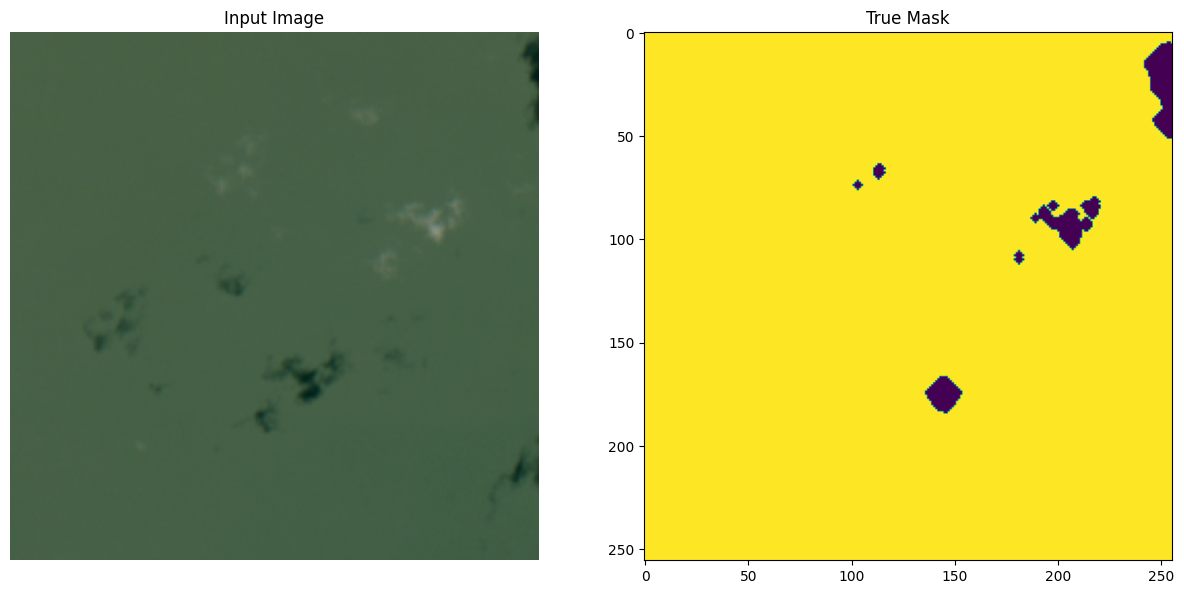

In [4]:
sample_image, sample_mask = X[5], y[5]
sample_image = sample_image[..., :4]
print(sample_image.shape)
print(sample_mask.shape)
display([sample_image, sample_mask])

### 1. Splitting the Dataset

In [4]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# example of 3 d image + mask image

### 2. Normalizing + one-hot-encoding

In [29]:
# one-hot-encoded labels ? shape of Y
test = y[0][:5, :5]
#test = np.array([[0,1,2], [0,1,2], [0,1,2], [0,1,2]])
#test = np.array([[0,0,0], [0,0,0], [0,0,0], [0,0,0]])

print(test.shape)
print(test)
# Convert the mask to one-hot encoding
num_classes = 3

test_one_hot = tf.one_hot(test, num_classes)
print(test_one_hot)

(4, 3)
[[0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]]
tf.Tensor(
[[[1. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]]

 [[1. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]]

 [[1. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]]

 [[1. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]]], shape=(4, 3, 3), dtype=float32)


In [3]:
# Apply one-hot encoding to each item in the input array
y_one_hot = to_categorical(y, 3)
print(y_one_hot.shape)

(1251, 256, 256, 3)


In [4]:
X_normal = X /255
print(X_normal.shape)

(1251, 256, 256, 5)


In [7]:
print(np.max(X_normal))
print(np.min(X_normal))

print(np.max(X))
print(np.min(X))

print(np.max(y_one_hot)) # Todo error should be 2
print(np.min(y_one_hot))

print(np.max(y))
print(np.min(y))




1.0
0.0
255.0
0.0
1.0
0.0
2
0


### 3. Building the unet model

In [5]:
model = unet_2d(input_shape=(256, 256, 5), num_classes=3)
#model.summary()

2023-03-13 20:44:41.639313: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-13 20:44:41.639335: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-13 20:44:41.639349: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eomap): /proc/driver/nvidia/version does not exist
2023-03-13 20:44:41.639915: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 4. Training the model

In [6]:
model.compile(optimizer='adam',
              loss=categorical_crossentropy, # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model_history = model.fit(X_normal, y_one_hot, epochs=20, batch_size = 5, validation_split=0.2)

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

### 5. Saving the model

### 6. Analyzing the results
- predifined success metrics
- printing loss and validation functions
- making predictions

### 7. Summary